In [1]:
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text
import pandas as pd

In [3]:
df=pd.read_csv('spam.csv')
df.head(5)

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


In [8]:
df.drop(['Unnamed: 2','Unnamed: 3','Unnamed: 4'],axis=1,inplace=True)

In [9]:
df.rename(columns={'v1':'Category','v2':'Message'},inplace=True)

In [10]:
df

,Category,Message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."
...,...,...
5567,spam,This is the 2nd time we have tried 2 contact u...
5568,ham,Will �_ b going to esplanade fr home?
5569,ham,"Pity, * was in mood for that. So...any other s..."
5570,ham,The guy did some bitching but I acted like i'd...


In [11]:
df.groupby('Category').describe()

Message                                                            \
           count unique                                                top   
Category                                                                     
ham         4825   4516                             Sorry, I'll call later   
spam         747    653  Please call our customer service representativ...   

               
         freq  
Category       
ham        30  
spam        4

In [13]:
df['Category'].value_counts()

ham     4825
spam     747
Name: Category, dtype: int64

In [16]:
df_spam=df[df['Category']=='spam']
df_spam.shape

(747, 2)

In [15]:
df_ham=df[df['Category']=='ham']
df_ham.shape

(4825, 2)

In [17]:
df_ham_downsampled=df_ham.sample(df_spam.shape[0])
df_ham_downsampled.shape

(747, 2)

In [18]:
df_balanced=pd.concat([df_spam,df_ham_downsampled])

In [20]:
df_balanced['Category'].value_counts()

ham     747
spam    747
Name: Category, dtype: int64

In [21]:
df_balanced.sample(5)

,Category,Message
821,ham,On the road so cant txt
2734,ham,Can you do a mag meeting this avo at some point?
1360,ham,Yo dude guess who just got arrested the other day
2717,ham,Okie.. Thanx..
5074,spam,"This is the 2nd attempt to contract U, you hav..."


In [24]:
df_balanced['spam']=df_balanced['Category'].apply(lambda x: 1 if x=='spam' else 0)
df_balanced.sample(5)

,Category,Message,spam
1814,ham,HI ITS JESS I DONT KNOW IF YOU ARE AT WORK BUT...,0
1847,spam,FREE NOKIA Or Motorola with upto 12mths 1/2pri...,1
1806,spam,Todays Voda numbers ending 1225 are selected t...,1
3833,ham,Watching tv lor. Nice one then i like lor.,0
4341,ham,Ha! I wouldn't say that I just didn't read any...,0


In [25]:
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test=train_test_split(df_balanced['Message'],df_balanced['spam'],stratify=df_balanced['spam'])

In [26]:
X_train.head(4)

2266    <Forwarded from 88877>FREE entry into our �250...
3911    You have an important customer service announc...
563     GENT! We are trying to contact you. Last weeke...
5441    By the way, make sure u get train to worc fore...
Name: Message, dtype: object

In [28]:
bert_preprocess=hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3")
bert_encoder=hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/4")

In [29]:
def get_sentence_embedding(sentences):
    preprocessed_text=bert_preprocess(sentences)#will return a preprocessed text
    return bert_encoder(preprocessed_text)['pooled_output']
    

In [31]:
get_sentence_embedding(['I am learning bert','Hellow how are you'])

<tf.Tensor: shape=(2, 768), dtype=float32, numpy=
array([[-0.9367533 , -0.3939451 , -0.39405572, ..., -0.1701292 ,
        -0.68270797,  0.9446976 ],
       [-0.9367989 , -0.42374453, -0.759758  , ..., -0.49173048,
        -0.6846865 ,  0.94380754]], dtype=float32)>

In [33]:
#bert layers
text_input=tf.keras.layers.Input(shape=(),dtype=tf.string,name='text')
preprocessed_text=bert_preprocess(text_input)
outputs=bert_encoder(preprocessed_text)

#neural network layers
l=tf.keras.layers.Dropout(0.1,name='dropout')(outputs['pooled_output'])#'output' here isinput layer as it is a functional model so we need to provide a input
l=tf.keras.layers.Dense(1,activation='sigmoid',name='output')(l)

#constructing a final model
model=tf.keras.Model(inputs=[text_input],outputs=[l])


In [34]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 text (InputLayer)              [(None,)]            0           []                               
                                                                                                  
 keras_layer_1 (KerasLayer)     {'input_type_ids':   0           ['text[0][0]']                   
                                (None, 128),                                                      
                                 'input_mask': (Non                                               
                                e, 128),                                                          
                                 'input_word_ids':                                                
                                (None, 128)}                                                  

In [36]:
METRICS=[
    tf.keras.metrics.BinaryAccuracy(name='accuracy'),
    tf.keras.metrics.Precision(name='precision'),
    tf.keras.metrics.Recall(name='recall')
]
model.compile(optimizer='adam',
             loss='binary_crossentropy',
             metrics=METRICS)

In [37]:
model.fit(X_train,y_train,epochs=10)

Epoch 1/10
35/35 [==============================] - 268s 7s/step - loss: 0.6520 - accuracy: 0.6125 - precision: 0.6291 - recall: 0.5482
Epoch 2/10
35/35 [==============================] - 348s 10s/step - loss: 0.5205 - accuracy: 0.7937 - precision: 0.7719 - recall: 0.8339
Epoch 3/10
35/35 [==============================] - 269s 8s/step - loss: 0.4463 - accuracy: 0.8518 - precision: 0.8518 - recall: 0.8518
Epoch 4/10
35/35 [==============================] - 292s 8s/step - loss: 0.3978 - accuracy: 0.8830 - precision: 0.8757 - recall: 0.8929
Epoch 5/10
35/35 [==============================] - 292s 8s/step - loss: 0.3688 - accuracy: 0.8875 - precision: 0.8666 - recall: 0.9161
Epoch 6/10
35/35 [==============================] - 279s 8s/step - loss: 0.3471 - accuracy: 0.8848 - precision: 0.8761 - recall: 0.8964
Epoch 7/10
35/35 [==============================] - 273s 8s/step - loss: 0.3236 - accuracy: 0.8982 - precision: 0.8912 - recall: 0.9071
Epoch 8/10
35/35 [=============================

In [38]:
model.evaluate(X_test,y_test)

12/12 [==============================] - 78s 6s/step - loss: 0.2711 - accuracy: 0.9305 - precision: 0.9351 - recall: 0.9251


[0.27113404870033264,
 0.9304812550544739,
 0.9351351261138916,
 0.9251337051391602]

In [40]:
y_predict=model.predict(X_test)
y_predicted=y_predict.flatten()

In [41]:
import numpy as np

y_predicted=np.where(y_predicted>0.5,1,0)
y_predicted

array([1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0,
       0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1,
       1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1,
       1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0,
       0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1,
       0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1,
       0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0,
       1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1,
       0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0,
       0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0,
       1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0,
       0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1,
       1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1,
       0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1,

In [42]:
from sklearn.metrics import confusion_matrix,classification_report

cm=confusion_matrix(y_test,y_predicted)
cm

array([[175,  12],
       [ 14, 173]], dtype=int64)

Text(33.0, 0.5, 'Truth')

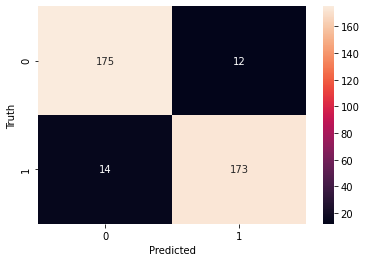

In [43]:
from matplotlib import pyplot as plt
import seaborn as sn
sn.heatmap(cm,annot=True,fmt='d')
plt.xlabel('Predicted')
plt.ylabel('Truth')

In [44]:
print(classification_report(y_test,y_predicted))

              precision    recall  f1-score   support

           0       0.93      0.94      0.93       187
           1       0.94      0.93      0.93       187

    accuracy                           0.93       374
   macro avg       0.93      0.93      0.93       374
weighted avg       0.93      0.93      0.93       374



In [45]:
model.save("saved_models/1/")

INFO:tensorflow:Assets written to: saved_models/1/assets


INFO:tensorflow:Assets written to: saved_models/1/assets


In [46]:
model.save("saved_models/2/")

INFO:tensorflow:Assets written to: saved_models/2/assets


INFO:tensorflow:Assets written to: saved_models/2/assets


In [47]:
model.save("saved_models/3/")

INFO:tensorflow:Assets written to: saved_models/3/assets


INFO:tensorflow:Assets written to: saved_models/3/assets
